# Clustering Project Workbook


##################################################################################################################
### This workbook serves as a rough draft for the final report, and is in no way the best looking or the most organized. Even when done, there is plenty of room for improvement. This is a brain dump if you will, it has a bunch of extra un-needed stuff. 
##################################################################################################################

____
![Image of Zillow Logo](https://www.roundtablerealty.com/uploads/agent-1/699119.png)




### Zillow: What is driving the errors in the Zestimates?
#### Background:
 Zillow, a real estate website in the United States, uses a Zestimate to estimate a property's market value.
> What is a Zestimate?     & 
How is the Zestimate calculated? - zillow.com

> For this project, we will look into finding drivers of error in the Zestimate. Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error.

### Project Goals:
 - Using Zillow data for single unit/single family homes sold in 2017, find drivers of log error in the Zestimate.

 - Create 4 regression models to predict log error

 - Use clustering methodologies to help identify drivers of log error

 - Deliver findings in a final Jupyter Notebook presentation

## Executive Summary:
#### Findings Include:
#### Takeaways:
#### Next Steps to Explore Further:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
import env

# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import wrangle

In [2]:
df = wrangle.get_zillow_data()
df = df.dropna()

In [3]:
df.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip    fips  \
0       4.0        3.5      3100.0      1998.0      96978.0  6059.0   
1       2.0        1.0      1465.0      1967.0      97099.0  6111.0   
2       3.0        2.0      1243.0      1962.0      97078.0  6059.0   
3       4.0        3.0      2376.0      1970.0      96330.0  6037.0   
4       4.0        3.0      2962.0      1950.0      96293.0  6037.0   

   tax_value  logerror transactiondate    longitude    latitude  
0  1023282.0  0.025595      2017-01-01 -117869207.0  33634931.0  
1   464000.0  0.055619      2017-01-01 -119281531.0  34449266.0  
2   564778.0  0.005383      2017-01-01 -117823170.0  33886168.0  
3   145143.0 -0.103410      2017-01-01 -118240722.0  34245180.0  
4   773303.0 -0.001011      2017-01-01 -118179824.0  34145202.0

____

# Explore

In [4]:
df.shape

(52301, 11)

In [5]:
df.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip    fips  \
0       4.0        3.5      3100.0      1998.0      96978.0  6059.0   
1       2.0        1.0      1465.0      1967.0      97099.0  6111.0   
2       3.0        2.0      1243.0      1962.0      97078.0  6059.0   
3       4.0        3.0      2376.0      1970.0      96330.0  6037.0   
4       4.0        3.0      2962.0      1950.0      96293.0  6037.0   

   tax_value  logerror transactiondate    longitude    latitude  
0  1023282.0  0.025595      2017-01-01 -117869207.0  33634931.0  
1   464000.0  0.055619      2017-01-01 -119281531.0  34449266.0  
2   564778.0  0.005383      2017-01-01 -117823170.0  33886168.0  
3   145143.0 -0.103410      2017-01-01 -118240722.0  34245180.0  
4   773303.0 -0.001011      2017-01-01 -118179824.0  34145202.0

In [6]:
# Check to see if nulls were removed
wrangle.nulls_by_col(df)

num_rows_missing  percent_rows_missing
bedrooms                        0                   0.0
bathrooms                       0                   0.0
squarefeet                      0                   0.0
year_built                      0                   0.0
regionidzip                     0                   0.0
fips                            0                   0.0
tax_value                       0                   0.0
logerror                        0                   0.0
transactiondate                 0                   0.0
longitude                       0                   0.0
latitude                        0                   0.0

In [7]:
wrangle.nulls_by_row(df)

num_cols_missing percent_cols_missing  index
0                0                  0.0  52301

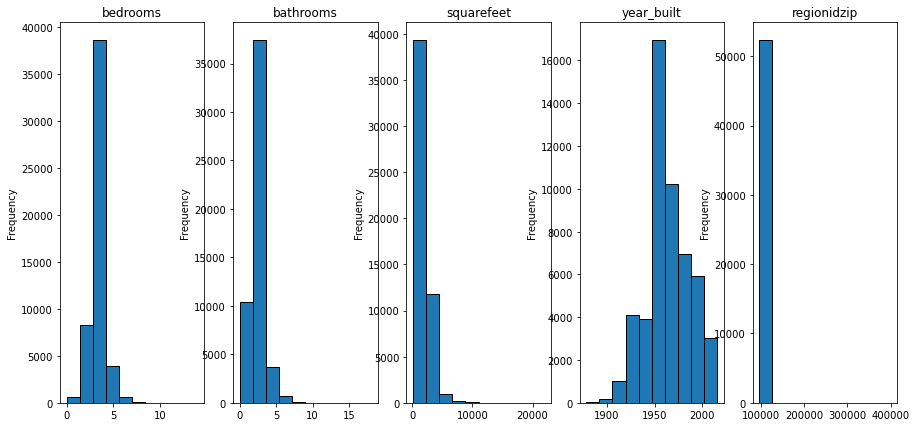

In [8]:
# Plot the distribution of some numeric variables
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

In [9]:
# Before exploring data further, we'll need to split data into train, validate and test, 
# so that we only explore on train. The data was split with 'wrangle.wrangle_zillow()' from wrangle.py module
train, validate, test = wrangle.wrangle_zillow()
train, validate, test = wrangle.Min_Max_Scaler(train, validate, test)
train.shape, validate.shape, test.shape

((25529, 12), (10942, 12), (9118, 12))

In [10]:
# Binning square footage for comparison and visualization purposes
train['squarefeet'] = df['squarefeet']
train['sq_ft_bins'] = pd.cut(train.squarefeet, [0, 1000, 2000, 3000, 4000, 10000])
train.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip  fips  \
36317         3        2.0      1252.0        1959        97104  6111   
26167         3        2.0      1274.0        1953        96201  6037   
635           4        2.5      2186.0        1986        97097  6111   
49331         4        3.0      2159.0        1964        97118  6111   
10086         4        2.0      1352.0        1954        96370  6037   

       tax_value  logerror transactiondate    longitude    latitude  \
36317   0.046060  0.034616      2017-07-03 -119189214.0  34170911.0   
26167   0.049221  0.168734      2017-05-23 -118087067.0  33931811.0   
635     0.607301  0.046620      2017-01-05 -118870664.0  34268267.0   
49331   0.321354 -0.001710      2017-09-01 -118736787.0  34254775.0   
10086   0.414059 -0.044853      2017-03-07 -118503960.0  34273188.0   

       years_old    sq_ft_bins  
36317         58  (1000, 2000]  
26167         64  (1000, 2000]  
635           31  (2000, 3000]  
49331         53  (2000, 3000]  
10086         63  (1000, 2000]

In [11]:
# Binning transactiondate for comparison and visualization purposes
train['years_old'] = 2017 - df['year_built']

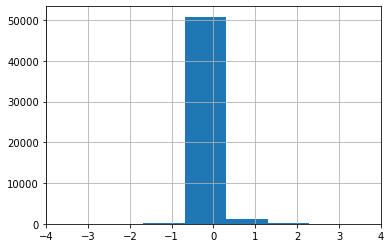

In [12]:
# A look at logerror:
df.logerror.hist()
plt.xlim(-4, 4);

In [13]:
df.logerror.max(), df.logerror.min(), df.logerror.mean(), df.logerror.median()

(5.2629986498, -4.65542037764, 0.01831105313921998, 0.00702230920515)

In [14]:
#Let's look at how variables are correlated
corr =  train.corr(method='pearson')

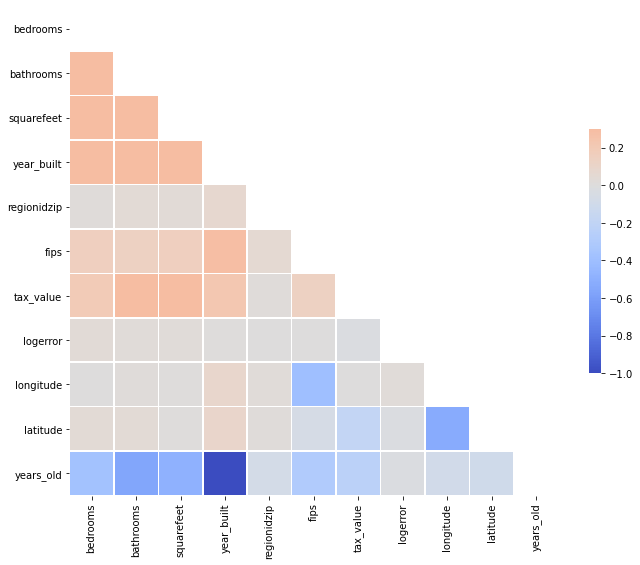

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### My first question:
## Does log error differ across square feet?

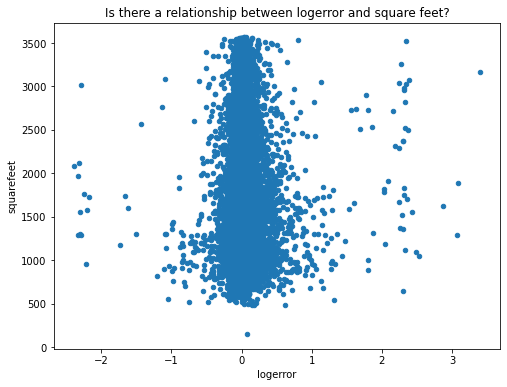

In [16]:
# Let's look at the relationship between log error and square feet
train.plot.scatter(
    x="logerror",
    y="squarefeet",
    title='Is there a relationship between logerror and square feet?',
    figsize=(8, 6),
);

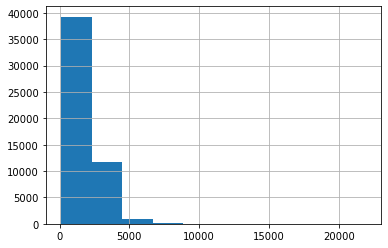

In [17]:
# Distribution of square footage 
df.squarefeet.hist();

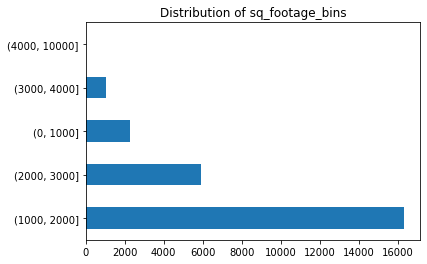

In [18]:
# Distribution of square footage by bins
# Looks like most properties are between 1,000-2,000 square feet

train.sq_ft_bins.value_counts().plot.barh(title='Distribution of sq_footage_bins');

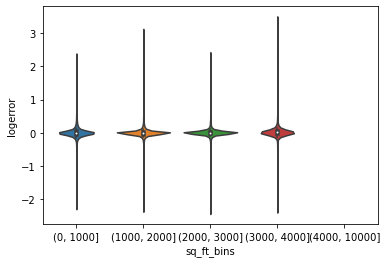

In [19]:
# Let's look at how log error compares across square footage by bins
# It doesn't look like there's much difference 
sns.violinplot(data=train, y='logerror', x='sq_ft_bins');

## Levene's Test: test for equal variance
$Ho$: There is no difference in logerror variance between the square footage

$Ha$: There is a difference in logerror variance between the square footage

In [20]:
stats.levene(
    train[train.squarefeet <= 1000].logerror,
    train[train.squarefeet > 1000].logerror,
)

LeveneResult(statistic=86.87833861645642, pvalue=1.24449903077096e-20)

In [21]:
stats.levene(
    train[train.squarefeet <= 2000].logerror,
    train[train.squarefeet > 2000].logerror,
)

LeveneResult(statistic=11.989677645876974, pvalue=0.0005358365818746686)

In [22]:
stats.levene(
    train[train.squarefeet <= 3000].logerror,
    train[train.squarefeet > 3000].logerror,
)

LeveneResult(statistic=3.547590667441237, pvalue=0.05964333538943036)

In [23]:
stats.levene(
    train[train.squarefeet <= 4000].logerror,
    train[train.squarefeet > 4000].logerror,
)

LeveneResult(statistic=nan, pvalue=nan)

### Create independent statistical tests to check for dependency amongst variables

In [24]:
stats.ttest_ind(
    train[train.squarefeet <= 1000].logerror,
    train[train.squarefeet > 1000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=0.5041477509972719, pvalue=0.6142009824146777)

In [25]:
stats.ttest_ind(
    train[train.squarefeet <= 2000].logerror,
    train[train.squarefeet > 2000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.674728933732915, pvalue=0.00023913301596827926)

In [26]:
stats.ttest_ind(
    train[train.squarefeet <= 3000].logerror,
    train[train.squarefeet > 3000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-2.4465849878412915, pvalue=0.014576683244536417)

In [27]:
stats.ttest_ind(
    train[train.squarefeet <= 4000].logerror,
    train[train.squarefeet > 4000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=nan, pvalue=nan)

### Conclusion:
We reject the null hypothesis that the logerror is the same for all square footages.

-----

### Hypothesis :
$Ho$ : Null Hypothesis: There is no correlation between square footage and log error

$Ha$ : Alternative Hypothesis: Square footage and log error are correlated

In [28]:
train = train.dropna()
test = test.dropna()
validate = validate.dropna()

In [29]:
x = train.squarefeet
y = train.logerror

In [30]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.028349143333460468, 5.891191267216062e-06)

In [31]:
# Null hypothesis is rejected.  Square footage and log error are correlated.

### My second question: 
## Does log error differ across county?

In [32]:
df.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip    fips  \
0       4.0        3.5      3100.0      1998.0      96978.0  6059.0   
1       2.0        1.0      1465.0      1967.0      97099.0  6111.0   
2       3.0        2.0      1243.0      1962.0      97078.0  6059.0   
3       4.0        3.0      2376.0      1970.0      96330.0  6037.0   
4       4.0        3.0      2962.0      1950.0      96293.0  6037.0   

   tax_value  logerror transactiondate    longitude    latitude  
0  1023282.0  0.025595      2017-01-01 -117869207.0  33634931.0  
1   464000.0  0.055619      2017-01-01 -119281531.0  34449266.0  
2   564778.0  0.005383      2017-01-01 -117823170.0  33886168.0  
3   145143.0 -0.103410      2017-01-01 -118240722.0  34245180.0  
4   773303.0 -0.001011      2017-01-01 -118179824.0  34145202.0

In [33]:
# Look at how counties compare in number
### 6037 = Los Angeles County
### 6059 = Orange County
### 6111 = Ventura County
df.fips.value_counts()

6037.0    33868
6059.0    14079
6111.0     4354
Name: fips, dtype: int64

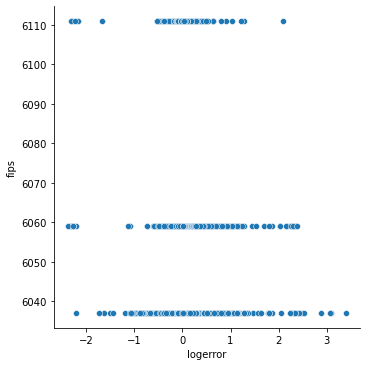

In [34]:
#Look at how log error compares amongst counties
sns.relplot(data=train, x='logerror', y='fips');

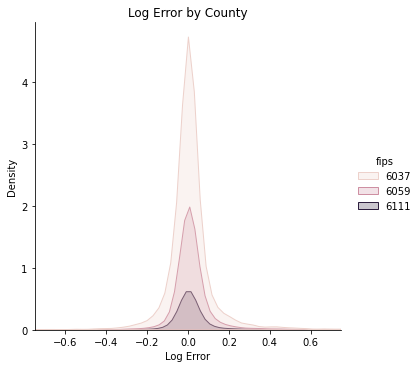

In [35]:
#Plotting distribution of log error by county
# 6037 (Los Angeles)
# 6059 (Orange)
# 6111 (Ventura)
sns.displot(train, x='logerror', hue='fips', kind='kde', fill=True)
plt.title('Log Error by County')
plt.xlabel('Log Error')
plt.xlim(-0.75, 0.75)
plt.show()

### Levene's Test: test for equal variance
$Ho$: There is no difference in logerror variance between the counties

$Ha$: There is a difference in logerror variance between the counties

In [36]:
train['county'] = train['fips']

stats.levene(
    train[train.county == 6037.0].logerror,
    train[train.county != 6037.0].logerror,
)

LeveneResult(statistic=30.01233549473158, pvalue=4.333586430633437e-08)

In [37]:
stats.levene(
    train[train.county == 6059.0].logerror,
    train[train.county != 6059.0].logerror,
)

LeveneResult(statistic=10.959310962964059, pvalue=0.0009326352705803517)

In [38]:
stats.levene(
    train[train.county == 6111.0].logerror,
    train[train.county != 6111.0].logerror,
)

LeveneResult(statistic=17.381368082449242, pvalue=3.06817209619698e-05)

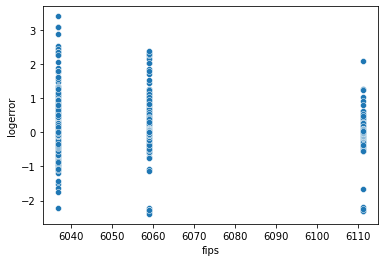

In [39]:
sns.scatterplot(data=train, y='logerror', x='fips');

### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all counties. The variance is not equal.

### My third question:
## Question 3: If we control for month, does log error differ across county?
1. Viz logerror by county for each month bin


2. Analyze each month bin separately

In [40]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['month'] = pd.DatetimeIndex(train['transactiondate']).month

#Binning transactiondate for comparison and visualization purposes
train['month_bins'] = pd.cut(train.month, [0,3,6,9,12])

train['county'] = train['fips'].apply(
        lambda x: 'Los Angeles' if x == 6037\
        else 'Orange' if x == 6059\
        else 'Ventura')

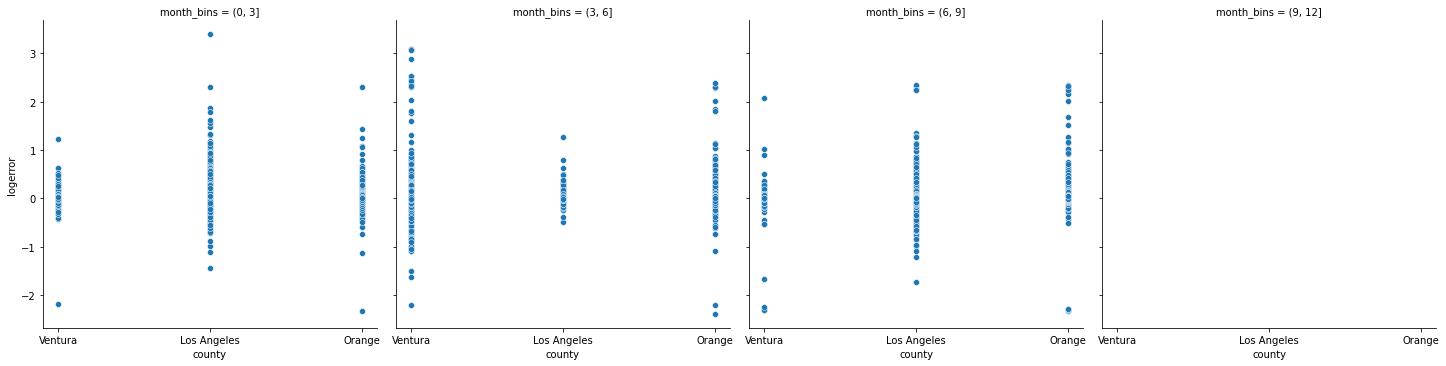

In [41]:
sns.relplot(data=train, y='logerror', x='county', col='month_bins');

In [42]:
# Logerror does not seem to vary much by month or county

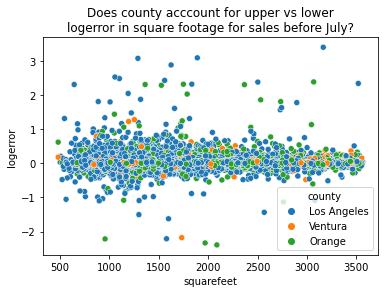

In [43]:
sns.scatterplot(
    x='squarefeet',
    y='logerror',
    data=train[train.month <= 6],
    hue='county',
)
plt.title("Does county acccount for upper vs lower\nlogerror in square footage for sales before July?");

In [44]:
# For sales before July 1st, log error may be grouped by county where Orange County and LA County have higher errors.

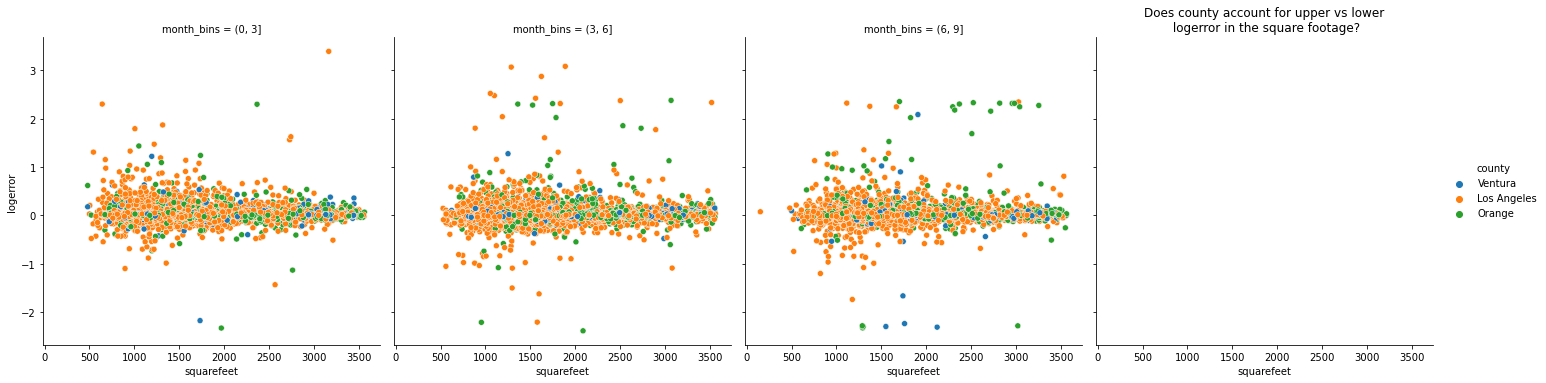

In [45]:
sns.relplot(
    x='squarefeet',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?");

In [46]:
# Orange County seems to have higher log errors compared to the other counties, 
# especially during the months of June-Sept.  Los Angeles county seems to have more variance in error, being more 
# scattered on both sides of 0.

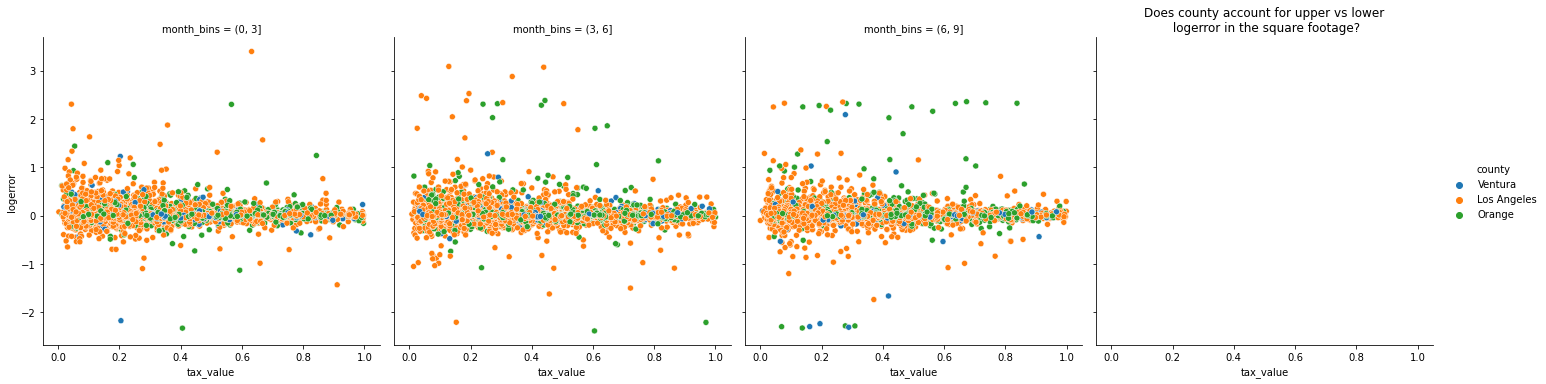

In [47]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins'
)


plt.title("Does county account for upper vs lower\n logerror in the square footage?");

In [48]:
# Comparing using tax value, Orange County still seems to have the highest log errors, especially during June-Sept

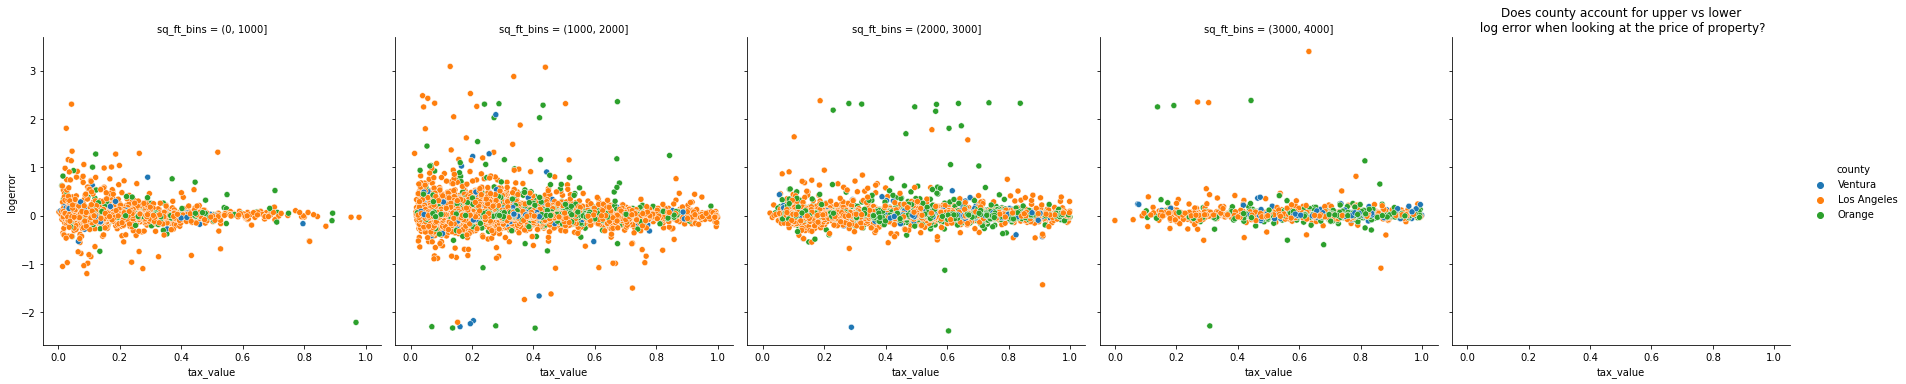

In [49]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='sq_ft_bins',
)

plt.title("Does county account for upper vs lower\n log error when looking at the price of property?");

In [50]:
# Comparing using tax value, Orange County accounts for most of the upper band seen in the log error 
# (higher lognerror) especially for homes between 2,000-3,000 square feet.
# Overall, county does seem to be grouped together for certain months and certain square footage

### My fourth question:
## Question 4: Does log error differ for different number of bedrooms?

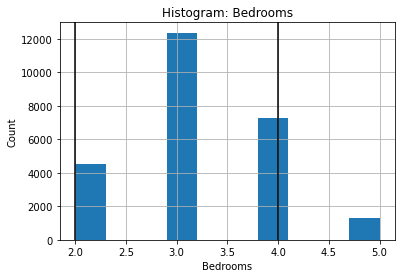

In [51]:
ax = train.bedrooms.hist()
plt.title('Histogram: Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
ax.axvline(2, color='black')
ax.axvline(4, color='black');

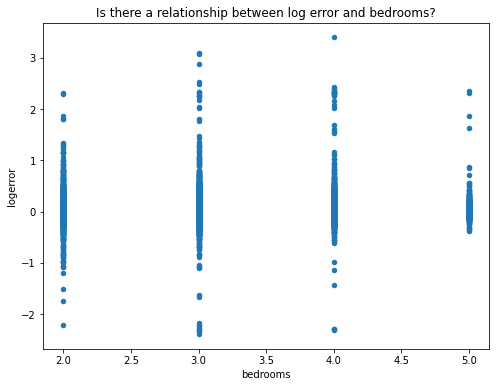

In [52]:
train.plot.scatter(
    y="logerror",
    x="bedrooms",
    title='Is there a relationship between log error and bedrooms?',
    figsize=(8, 6),
);

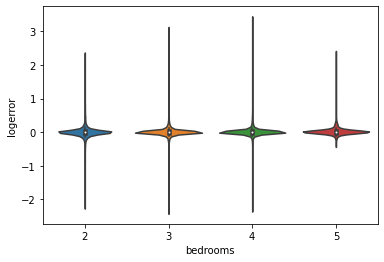

In [53]:
sns.violinplot(data=train, y='logerror', x='bedrooms');

### Levene's Test: test for equal variance
$Ho$: There is no difference in logerror variance for different number of bedrooms

$Ha$: There is a difference in logerror variance different number of bedrooms

In [54]:
stats.levene(
    train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
)

LeveneResult(statistic=4.195211649779681, pvalue=0.04054849950098029)

In [55]:
# We fail to reject the null hypothesis that there is no difference in logerror variance for different number of bedrooms.
# The variance is equal.

### Is the log error the same for properties with 4 or less as those with more than 4 bedrooms?
$Ho$: The logerror is the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms

$Ha$: The logerror is not the same for properties with 4 bedrooms or less as with those with 5 bedrooms

In [56]:
stats.ttest_ind(
   train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-3.266964236906971, pvalue=0.0010885087985330435)

### Conclusion:
We reject the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with 5 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with 5 bedrooms.

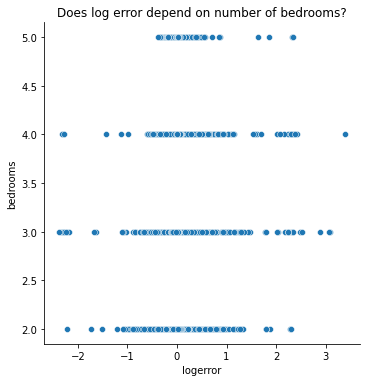

In [57]:
sns.relplot(
    y='bedrooms',
    x='logerror',
    data=train,
)
plt.title("Does log error depend on number of bedrooms?");

### Hypothesis:
$Ho$: There is no correlation between number of bedrooms and log error

$Ha$: Number of bedrooms and log error are correlated

In [58]:
x = train.bedrooms
y = train.logerror

In [59]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.03228514619664904, 2.4754745517100843e-07)

#### Null hypothesis is rejected.  Number of bedrooms and log error are correlated.

# Clustering
### Use Clustering to Identify Possible Features of Interest
 - We do not any features indicating location near the coast, so we will look at latitude and longitude features to see if we can create a possible feature of interest for modeling and predicting

## Clustering Model # 1:

In [60]:
# Choose two features to create possible cluster
# define independent variables for k-means

X = train[['latitude', 'longitude']]
scaler = MinMaxScaler().fit(X)
X_scaled_lat_long = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing and create 3 clusters
kmeans = KMeans(n_clusters=3, random_state=321)

# fit the thing
kmeans.fit(X_scaled_lat_long )

# Use (predict using) the thing 
kmeans.predict(X_scaled_lat_long )
train['cluster'] = kmeans.predict(X_scaled_lat_long )

X_scaled_lat_long['cluster'] = kmeans.predict(X_scaled_lat_long )

# look at the dataframe
X_scaled_lat_long.head()

latitude  longitude  cluster
36317  0.561711   0.136859        1
26167  0.399954   0.718849        2
635    0.627574   0.305070        1
49331  0.618447   0.375764        1
10086  0.630903   0.498708        1

In [61]:
#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_long'] = train['cluster']

#Check to see if it was created
train.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip  fips  \
36317         3        2.0      1252.0        1959        97104  6111   
26167         3        2.0      1274.0        1953        96201  6037   
635           4        2.5      2186.0        1986        97097  6111   
49331         4        3.0      2159.0        1964        97118  6111   
10086         4        2.0      1352.0        1954        96370  6037   

       tax_value  logerror transactiondate    longitude    latitude  \
36317   0.046060  0.034616      2017-07-03 -119189214.0  34170911.0   
26167   0.049221  0.168734      2017-05-23 -118087067.0  33931811.0   
635     0.607301  0.046620      2017-01-05 -118870664.0  34268267.0   
49331   0.321354 -0.001710      2017-09-01 -118736787.0  34254775.0   
10086   0.414059 -0.044853      2017-03-07 -118503960.0  34273188.0   

       years_old    sq_ft_bins       county  month month_bins  cluster  \
36317       58.0  (1000, 2000]      Ventura      7     (6, 9]        1   
26167       64.0  (1000, 2000]  Los Angeles      5     (3, 6]        2   
635         31.0  (2000, 3000]      Ventura      1     (0, 3]        1   
49331       53.0  (2000, 3000]      Ventura      9     (6, 9]        1   
10086       63.0  (1000, 2000]  Los Angeles      3     (0, 3]        1   

       cluster_lat_long  
36317                 1  
26167                 2  
635                   1  
49331                 1  
10086                 1

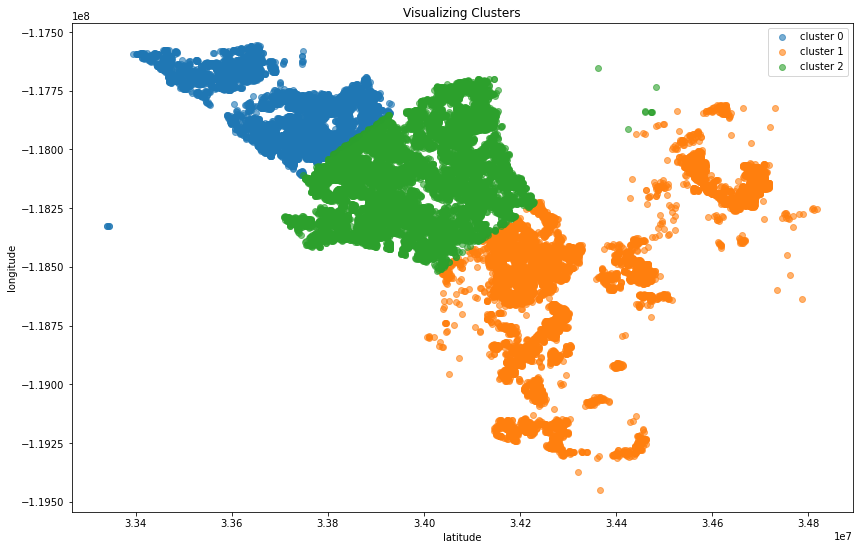

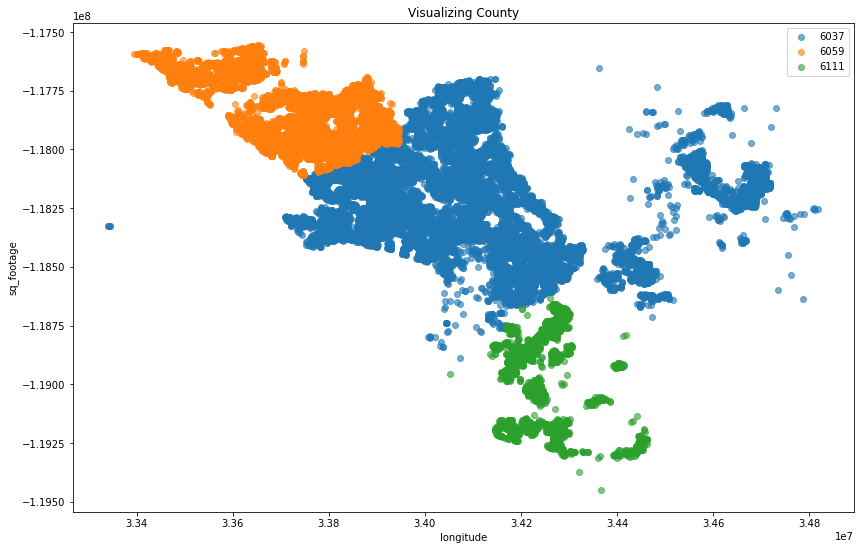

In [62]:
# Visualize the clusters by plotting them 
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Clusters')
plt.show()

# Compare against the actual data by county to compare how the clustering did
plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('fips'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)

plt.legend()
plt.xlabel('longitude')
plt.ylabel('sq_footage')
plt.title('Visualizing County')
plt.show();

## Clustering Model # 2:

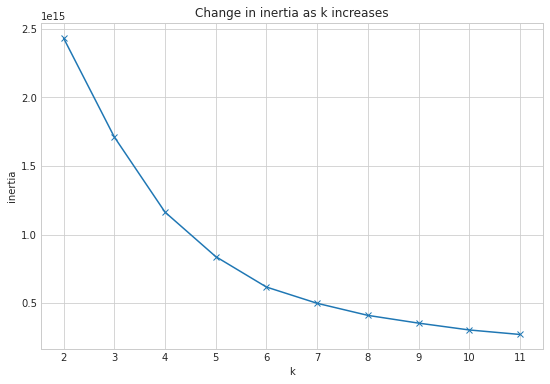

In [63]:
# we will create more clusters on the same features using a different k for grouping

X = train[['latitude', 'longitude']]
wrangle.inertia_plot(X)

In [64]:
# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_lat_long_k5, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_k5'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_k5'] = pd.to_numeric(train['cluster_lat_long_k5'],errors='coerce')

#Check to see if it was created
train.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip  fips  \
36317         3        2.0      1252.0        1959        97104  6111   
26167         3        2.0      1274.0        1953        96201  6037   
635           4        2.5      2186.0        1986        97097  6111   
49331         4        3.0      2159.0        1964        97118  6111   
10086         4        2.0      1352.0        1954        96370  6037   

       tax_value  logerror transactiondate    longitude    latitude  \
36317   0.046060  0.034616      2017-07-03 -119189214.0  34170911.0   
26167   0.049221  0.168734      2017-05-23 -118087067.0  33931811.0   
635     0.607301  0.046620      2017-01-05 -118870664.0  34268267.0   
49331   0.321354 -0.001710      2017-09-01 -118736787.0  34254775.0   
10086   0.414059 -0.044853      2017-03-07 -118503960.0  34273188.0   

       years_old    sq_ft_bins       county  month month_bins    cluster  \
36317       58.0  (1000, 2000]      Ventura      7     (6, 9]  cluster_0   
26167       64.0  (1000, 2000]  Los Angeles      5     (3, 6]  cluster_1   
635         31.0  (2000, 3000]      Ventura      1     (0, 3]  cluster_0   
49331       53.0  (2000, 3000]      Ventura      9     (6, 9]  cluster_0   
10086       63.0  (1000, 2000]  Los Angeles      3     (0, 3]  cluster_2   

       cluster_lat_long  cluster_lat_long_k5  
36317                 1                    0  
26167                 2                    1  
635                   1                    0  
49331                 1                    0  
10086                 1                    2

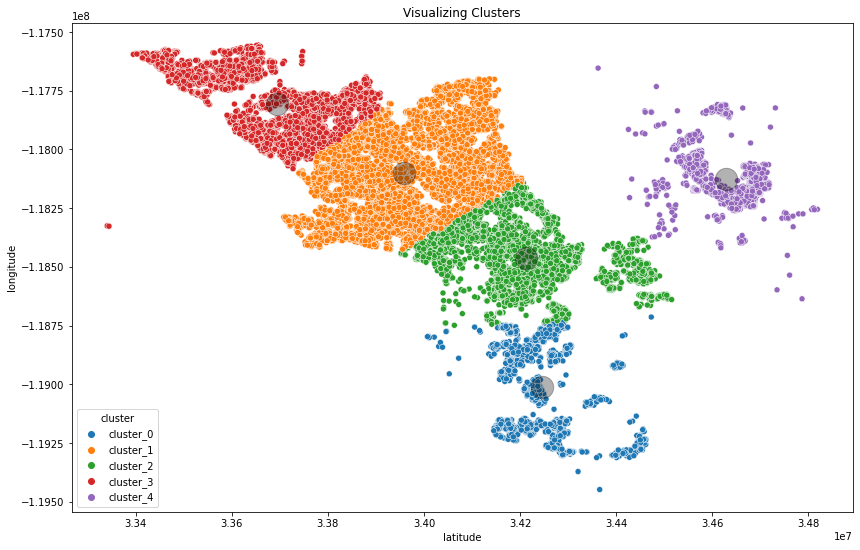

In [65]:
# use the create_scatter_plot function from wrangle.py to plot the data

wrangle.create_scatter_plot('latitude', 'longitude',train,kmeans, X_scaled_lat_long_k5, scaler)

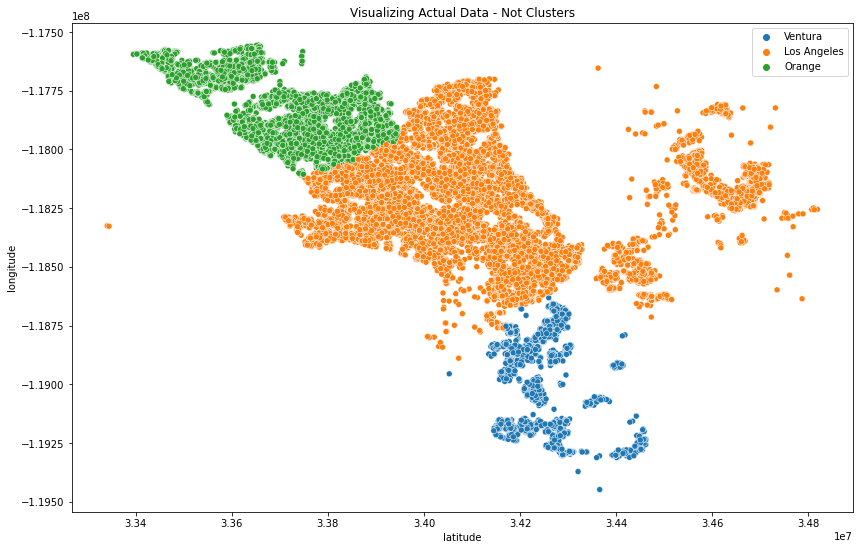

In [66]:
# Even though we only have 3 counties, the grouping by cluster looks good in this model and may be 
# helpful for predicting log error


# Compare to actual county boundaries again
wrangle.plot_actual(train, 'county', 'latitude', 'longitude')

## Clustering Model # 3:
#### Repeat the clustering, this time with 3 different features.

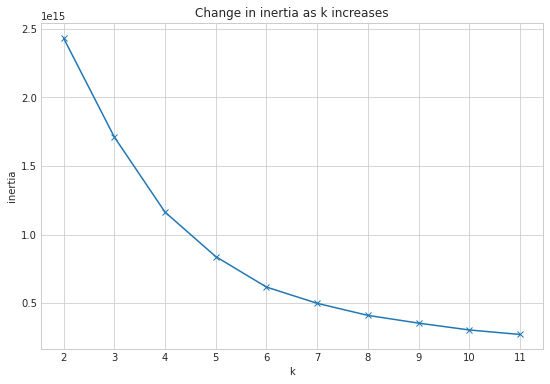

In [67]:
# we will create cluster on three features

X = train[['latitude','longitude','squarefeet']]
wrangle.inertia_plot(X)

In [68]:
# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_lat_long_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_sqft'] = pd.to_numeric(train['cluster_lat_long_sqft'],errors='coerce')

#Check to see if it was created
train.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip  fips  \
36317         3        2.0      1252.0        1959        97104  6111   
26167         3        2.0      1274.0        1953        96201  6037   
635           4        2.5      2186.0        1986        97097  6111   
49331         4        3.0      2159.0        1964        97118  6111   
10086         4        2.0      1352.0        1954        96370  6037   

       tax_value  logerror transactiondate    longitude    latitude  \
36317   0.046060  0.034616      2017-07-03 -119189214.0  34170911.0   
26167   0.049221  0.168734      2017-05-23 -118087067.0  33931811.0   
635     0.607301  0.046620      2017-01-05 -118870664.0  34268267.0   
49331   0.321354 -0.001710      2017-09-01 -118736787.0  34254775.0   
10086   0.414059 -0.044853      2017-03-07 -118503960.0  34273188.0   

       years_old    sq_ft_bins       county  month month_bins    cluster  \
36317       58.0  (1000, 2000]      Ventura      7     (6, 9]  cluster_2   
26167       64.0  (1000, 2000]  Los Angeles      5     (3, 6]  cluster_1   
635         31.0  (2000, 3000]      Ventura      1     (0, 3]  cluster_2   
49331       53.0  (2000, 3000]      Ventura      9     (6, 9]  cluster_0   
10086       63.0  (1000, 2000]  Los Angeles      3     (0, 3]  cluster_2   

       cluster_lat_long  cluster_lat_long_k5  cluster_lat_long_sqft  
36317                 1                    0                      2  
26167                 2                    1                      1  
635                   1                    0                      2  
49331                 1                    0                      0  
10086                 1                    2                      2

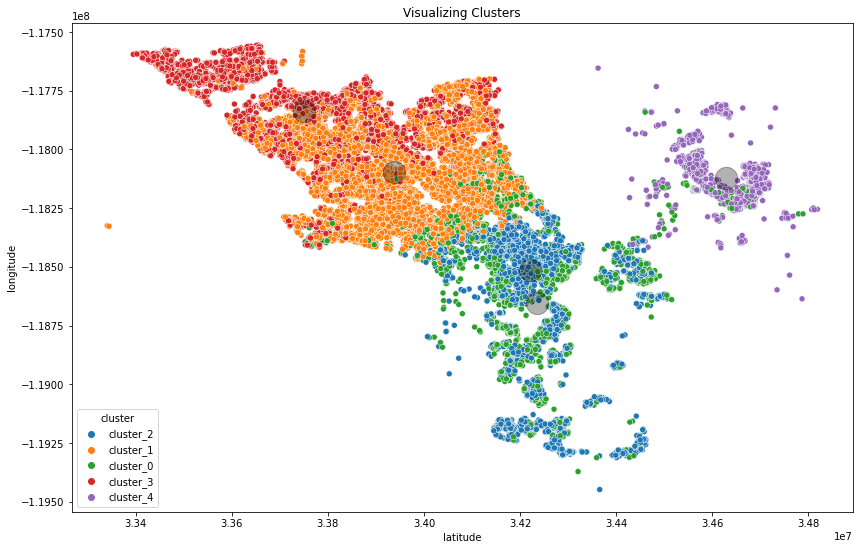

In [69]:
# use the create_scatter_plot function from wrangle.py to plot the cluster data

wrangle.create_scatter_plot('latitude', 'longitude', train, kmeans, X_scaled_lat_long_sqft, scaler)

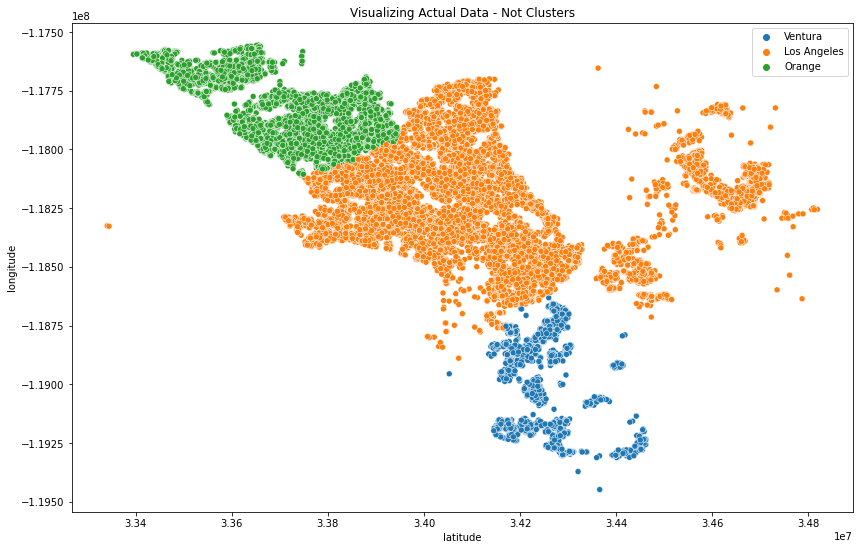

In [70]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'latitude', 'longitude')

In [71]:
# Since we're using 3 features for clustering, the clusters could be mapping to three dimensions and 
# thus why some are overlapping throughout.

## Clustering Model # 4:

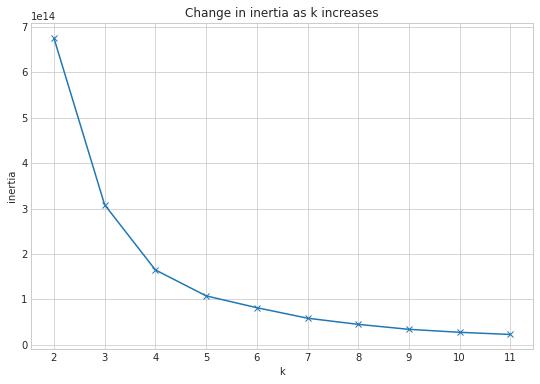

In [72]:
# we will create cluster on two other separate features
# Using latitude for location and square footage since it ranked high in relation to log error

X = train[['latitude','squarefeet']]

wrangle.inertia_plot(X)

In [73]:
# use the create cluster function from wrangle.py with k value from inertia plot

train, X_scaled_lat_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 4)

#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_sqft'] = pd.to_numeric(train['cluster_lat_sqft'],errors='coerce')

#Check to see if it was created
train.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip  fips  \
36317         3        2.0      1252.0        1959        97104  6111   
26167         3        2.0      1274.0        1953        96201  6037   
635           4        2.5      2186.0        1986        97097  6111   
49331         4        3.0      2159.0        1964        97118  6111   
10086         4        2.0      1352.0        1954        96370  6037   

       tax_value  logerror transactiondate    longitude  ...  years_old  \
36317   0.046060  0.034616      2017-07-03 -119189214.0  ...       58.0   
26167   0.049221  0.168734      2017-05-23 -118087067.0  ...       64.0   
635     0.607301  0.046620      2017-01-05 -118870664.0  ...       31.0   
49331   0.321354 -0.001710      2017-09-01 -118736787.0  ...       53.0   
10086   0.414059 -0.044853      2017-03-07 -118503960.0  ...       63.0   

         sq_ft_bins       county month  month_bins    cluster  \
36317  (1000, 2000]      Ventura     7      (6, 9]  cluster_2   
26167  (1000, 2000]  Los Angeles     5      (3, 6]  cluster_3   
635    (2000, 3000]      Ventura     1      (0, 3]  cluster_1   
49331  (2000, 3000]      Ventura     9      (6, 9]  cluster_1   
10086  (1000, 2000]  Los Angeles     3      (0, 3]  cluster_2   

      cluster_lat_long  cluster_lat_long_k5  cluster_lat_long_sqft  \
36317                1                    0                      2   
26167                2                    1                      1   
635                  1                    0                      2   
49331                1                    0                      0   
10086                1                    2                      2   

       cluster_lat_sqft  
36317                 2  
26167                 3  
635                   1  
49331                 1  
10086                 2  

[5 rows x 21 columns]

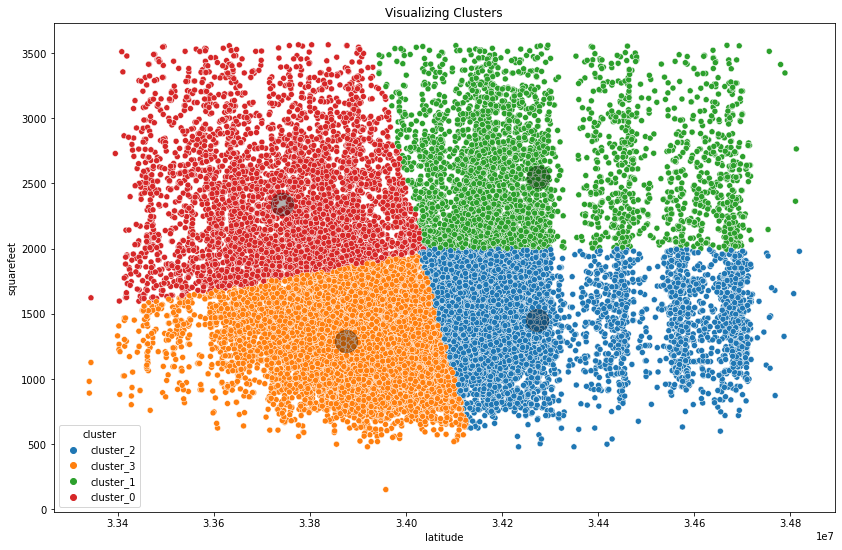

In [74]:
# use the create_scatter_plot function from wrangle.py to plot the cluster data

wrangle.create_scatter_plot('latitude', 'squarefeet',train, kmeans, X_scaled_lat_sqft, scaler)

In [75]:
# Clusters are broken down into 4 groups:

# Cluster_0 - Latitude between about 3.34 - 3.39 and Square Footage up to about 2500 sq ft
# Cluster_1 - Latitude between about 3.42 - 3.48 and Square Footage from about 500 sq ft to up to over 4000 sq ft
# Cluster_2 - Latitude between about 3.39 - 3.45 and Square Footage up to 2500 sq ft
# Cluster_3 - Latitude between about 3.34 - 3.48 and Square Footage over 2000 sq ft

# Clusters do not map clearly to corresponding counties.
# Counties overlap on latitude 
# Most properties seem to be under 3000 sq feet and in Los Angeles county

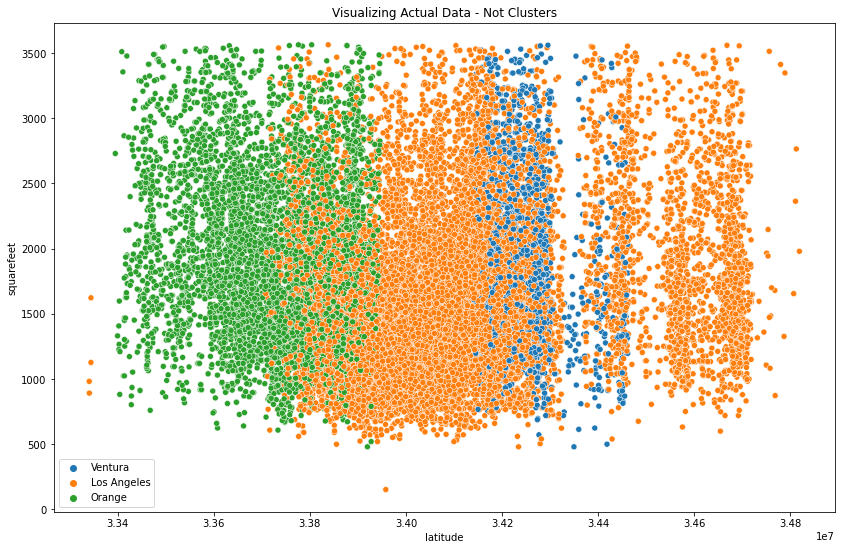

In [76]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'latitude', 'squarefeet')

## Clustering Model # 5:

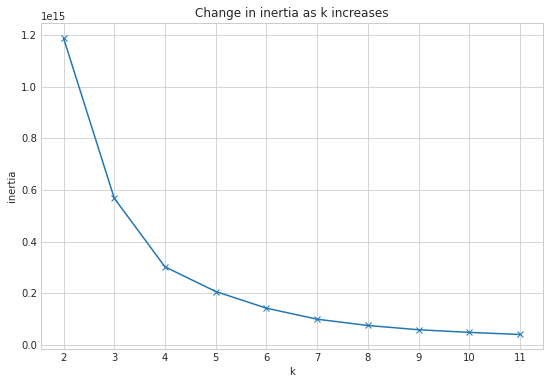

In [77]:
# we will create cluster on two other separate features
#Using longitude for location and square footage since it ranked high in relation to log error

X = train[['longitude','squarefeet']]

wrangle.inertia_plot(X)

In [78]:
# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_long_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 4)

#Save this clustering for use in independence testing and possible modeling
train['cluster_long_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_long_sqft'] = pd.to_numeric(train['cluster_long_sqft'],errors='coerce')

#Check to see if it was created
train.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip  fips  \
36317         3        2.0      1252.0        1959        97104  6111   
26167         3        2.0      1274.0        1953        96201  6037   
635           4        2.5      2186.0        1986        97097  6111   
49331         4        3.0      2159.0        1964        97118  6111   
10086         4        2.0      1352.0        1954        96370  6037   

       tax_value  logerror transactiondate    longitude  ...    sq_ft_bins  \
36317   0.046060  0.034616      2017-07-03 -119189214.0  ...  (1000, 2000]   
26167   0.049221  0.168734      2017-05-23 -118087067.0  ...  (1000, 2000]   
635     0.607301  0.046620      2017-01-05 -118870664.0  ...  (2000, 3000]   
49331   0.321354 -0.001710      2017-09-01 -118736787.0  ...  (2000, 3000]   
10086   0.414059 -0.044853      2017-03-07 -118503960.0  ...  (1000, 2000]   

            county month month_bins    cluster cluster_lat_long  \
36317      Ventura     7     (6, 9]  cluster_2                1   
26167  Los Angeles     5     (3, 6]  cluster_0                2   
635        Ventura     1     (0, 3]  cluster_2                1   
49331      Ventura     9     (6, 9]  cluster_2                1   
10086  Los Angeles     3     (0, 3]  cluster_0                1   

      cluster_lat_long_k5  cluster_lat_long_sqft  cluster_lat_sqft  \
36317                   0                      2                 2   
26167                   1                      1                 3   
635                     0                      2                 1   
49331                   0                      0                 1   
10086                   2                      2                 2   

       cluster_long_sqft  
36317                  2  
26167                  0  
635                    2  
49331                  2  
10086                  0  

[5 rows x 22 columns]

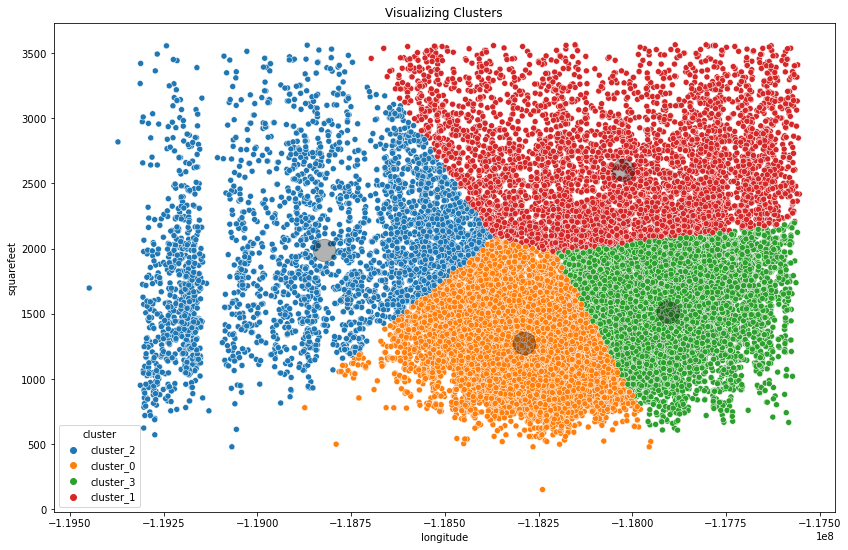

In [79]:
# use the create_scatter_plot function from wrangle.py to plot the cluster data
wrangle.create_scatter_plot('longitude', 'squarefeet',train,kmeans, X_scaled_long_sqft, scaler)

In [80]:
# Clusters are broken down into 4 groups:

# Cluster_0 - Longitude between about -1.1890 thru -1.1785 and Square Footage up to about 2000 sq ft
# Cluster_1 - Longitude between about -1.1880 thru -1.1750 and Square Footage above 2000 sq ft
# Cluster_2 - Longitude between about -1.1950 thru -1.1835 and Square Footage from 500 sq ft to over 4000 sq ft
# Cluster_3 - Longitude between about -1.1820 thru -1.1750 and Square Footage up to about 2000 sq ft

# Clusters do not map clearly to corresponding counties.
# Counties overlap on longitude 
# Most properties seem to be under 3000 sq feet and in Los Angeles county

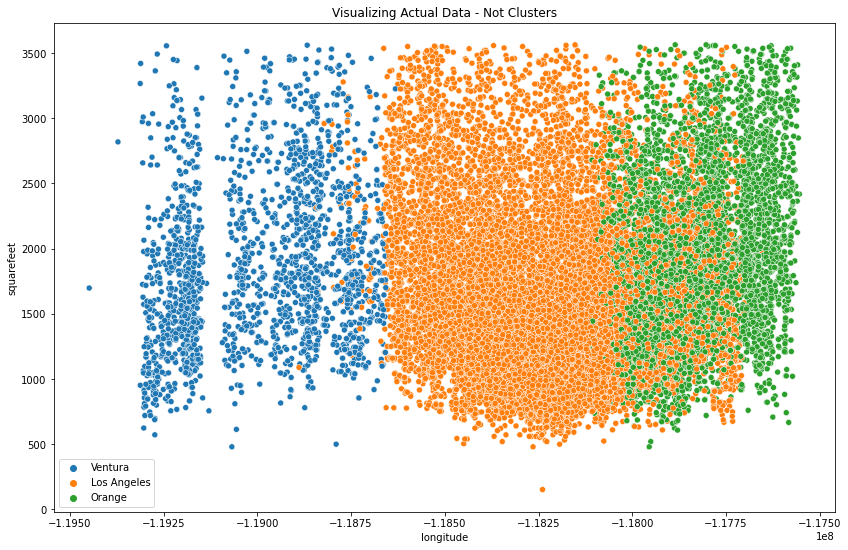

In [81]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'longitude', 'squarefeet')

### After exploring using clustering, we try statistical tests to check if latitude and longitude are correlated to log error:
$Ho$: There is no correlation between latitude and log error

$Ha$: Latitude and log error are correlated

In [82]:
x = train.latitude
y = train.logerror
corr, p = stats.pearsonr(x, y)
corr, p

(-0.020991105131190537, 0.000796173981469638)

In [83]:
# Null hypothesis is rejected.  Latitude and log error are correlated.

### Hypothesis:
$Ho$: There is no correlation between longitude and log error .

$Ha$: Longitude and log error are correlated.

In [84]:
x = train.longitude
y = train.logerror
corr, p = stats.pearsonr(x, y)
corr, p

(0.02319378310661404, 0.0002104148809666757)

In [85]:
# Null hypothesis is rejected.  Longitude and log error are correlated.
# Latitude and longitude are both correlated to log error and can be used for predictors of error in the model.

## Statistical Tests for Independence on Clusters
#### To compare if each cluster is independent of log error, we need to compare the overall log error mean to the mean of each cluster region to see if there is a signifant difference.
 - We need to compare the mean of the log error of each one compared to the mean of the log error of all clusters
 
 
## Cluster # 1 - Latitude and Longitude:

In [86]:
#Calculating overall log error mean to use for hypothesis testing
logerror_mean =  train.logerror.mean()

logerror_mean

0.016410461659818368

In [87]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_long.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_long == i].logerror.mean()
        difference = abs(logerror_mean - region_mean)
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        region_mean_df.append(
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            },
            ignore_index=True)
        print(region_mean_df)    
        i += 1

   region      mean  difference
0       0  0.024148    0.007738
   region      mean  difference
0       1  0.015308    0.001103
   region      mean  difference
0       2  0.013317    0.003093


In [88]:
# Creating a column with the log error values of cluster 0 since it had the biggest difference to run
# a statistical test  

clust_1_0 = train[train.cluster_lat_long == 0].logerror

### Clustering Hypothesis # 1
$Ho$: There is no relationship between logerror and cluster # 1 region # 3 

$Ha$: There is a relationship between logerror and cluster # 1 region # 3

In [89]:
stats.ttest_ind(train.logerror, clust_1_0)

Ttest_indResult(statistic=-3.227860521362777, pvalue=0.0012484812079437675)

### We rejected the null hypothesis. Cluster # 1 Region # 0 could be used to predict log error.

___

## Cluster # 2 - Latitude and Longitude with 5 clusters (k = 5)

In [90]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_long_k5.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_long_k5 == i].logerror.mean()      
        difference = abs(logerror_mean - region_mean)
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.011795    0.004616
   region      mean  difference
0       1  0.016362    0.000048
   region      mean  difference
0       2  0.012142    0.004268
   region      mean  difference
0       3  0.023617    0.007206
   region      mean  difference
0       4  0.013706    0.002705


In [91]:
# Creating a column with the log error values of cluster 2 since it had the biggest difference to run
# a statistical test  

clust_2_2 = train[train.cluster_lat_long_k5 == 2].logerror

### Clustering Hypothesis # 2
$Ho$: There is no relationship between logerror and cluster # 2 region # 2

$Ha$: There is a relationship between logerror and cluster # 2 region # 2

In [92]:
stats.ttest_ind(train.logerror, clust_2_2)

Ttest_indResult(statistic=1.7723755167170911, pvalue=0.07634202565879139)

### We reject the null hypothesis. Cluster # 2 Region # 2 can be used to predict log error and beat cluster # 1 in pvalue significance.

____

## Cluster # 3 - Latitude and Longitude with Square Footage

In [93]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_long_sqft.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_long_sqft == i].logerror.mean()
        difference = abs(logerror_mean - region_mean)   
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])       
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.018002    0.001591
   region      mean  difference
0       1  0.012998    0.003412
   region      mean  difference
0       2  0.013263    0.003148
   region      mean  difference
0       3  0.026637    0.010226
   region      mean  difference
0       4  0.012701    0.003709


In [94]:
# Creating a column with the log error values of cluster 3 since it had the biggest difference to run
# a statistical test  

clust_3_3 = train[train.cluster_lat_long_sqft == 3].logerror

### Clustering Hypothesis #3
$Ho$ : There is no relationship between logerror and cluster # 3 region # 3

$Ha$ : There is a relationship between logerror and cluster # 3 region # 3

In [95]:
stats.ttest_ind(train.logerror, clust_3_3)

Ttest_indResult(statistic=-4.093584708719563, pvalue=4.258350407702693e-05)

### Cluster # 3 rejects the null hypothesis that there is no relationship between log error and cluster # 3 region # 3.
This means it can be used to predict log error and it has the lowest pvalue yet which indicates it could be significant.

____

### Cluster # 4 - Latitude and Square Footage

In [96]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_sqft.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_sqft == i].logerror.mean()
        difference = abs(logerror_mean - region_mean)   
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.027038    0.010627
   region      mean  difference
0       1  0.016652    0.000241
   region      mean  difference
0       2  0.012468    0.003942
   region      mean  difference
0       3  0.014646    0.001764


In [97]:
# Creating a column with the log error values of cluster 3 since it had the biggest difference to run
# a statistical test  

clust_4_3 = train[train.cluster_lat_sqft == 3].logerror

### Clustering Hypothesis # 4
$Ho$: There is no relationship between logerror and cluster # 4 region # 3 

$Ha$: There is a relationship between logerror and cluster # 4 region # 3

In [98]:
stats.ttest_ind(train.logerror, clust_4_3)

Ttest_indResult(statistic=0.9077030013274758, pvalue=0.3640413577452971)

### Cluster # 4 Region # 3 rejects the null hypothesis that there is no relationship between log error and cluster # 4 region # 3.
This means it can be used to predict log error.

## Cluster # 5 - Longtitude and Square Footage

In [99]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_long_sqft.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_long_sqft == i].logerror.mean()       
        difference = abs(logerror_mean - region_mean)    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])        
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.010899    0.005512
   region     mean  difference
0       1  0.02579     0.00938
   region      mean  difference
0       2  0.012587    0.003823
   region      mean  difference
0       3  0.018649    0.002239


In [100]:
# Creating a column with the log error values of cluster 1 since it had the biggest difference to run
# a statistical test  

clust_5_1 = train[train.cluster_long_sqft == 1].logerror

### Clustering Hypothesis # 5
$Ho$: There is no relationship between logerror and cluster # 5 region # 1

$Ha$: There is a relationship between logerror and cluster # 5 region # 1

In [101]:
stats.ttest_ind(train.logerror, clust_5_1)

Ttest_indResult(statistic=-3.563566312496671, pvalue=0.0003664112286835943)

### Cluster # 5 rejects the null hypothesis and thus can be used to predict log error.
_____

## Exploration Takeaways:
- Top features correlated to log error are
   - sq_footage
   - bedrooms
   - bathrooms
- We rejected the null hypothesis that the logerror is the same for all square footages. Log error depends on square footage.
- We rejected the null hypothesis that the logerror is the same for all counties. Log error depends on the county.
- Orange County has the largest log error, followed by Los Angeles County
- Log error varies by month and by county
- We rejected the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than bedrooms.
- Clustering by latitude and longitude created clusters which mapped to the counties but looked to create an additional cluster which fit the map well.
- Latitude and longitude independent tests comparing log errors rejected the null hypothesis meaning they are correlated to log error.
- Log error is dependent on square footage and number of bedrooms.
- Cluster # 1 (Latitude/Longitude), # 3 (Lat/Long/Square Feet), # 4 (Latitude/Square Feet), # 5 (Longitude/Square Feet) rejected the null hypothesis that there was no relationship between log error so they can be used in modeling.

# Modeling

In [102]:
#In order to start modeling, we need to create out X and y for train, validate and test

#Set up x and y 
X_train = train[['latitude','longitude','squarefeet','bedrooms', 'bathrooms']]
X_validate = validate[['latitude','longitude','squarefeet','bedrooms', 'bathrooms']] 
X_test = test[['latitude','longitude','squarefeet','bedrooms','bathrooms']] 

#Scale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

y_train = train.logerror
y_validate = validate.logerror
y_test = test.logerror

### Let's look at the Target Variable (y)
This helps us determine which type of algorithm we may want to use.

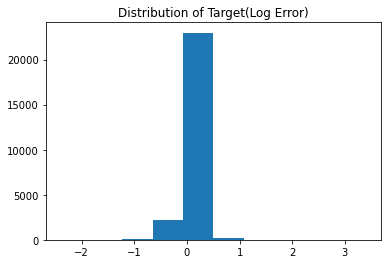

In [103]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(Log Error)');

In [104]:
len(y_train)

25529

In [105]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

## Feature Engineering
#### Recursive Feature Elimination
 - Fits a model and eliminates the worst performing features
 - Looks at all the features together

In [106]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(X_train, y_train)
rfe.get_support()

array([False, False, False,  True, False])

In [107]:
X_train.columns[rfe.get_support()]

Index(['bedrooms'], dtype='object')

In [108]:
pd.Series(rfe.ranking_, index=X_train.columns)

latitude      4
longitude     5
squarefeet    3
bedrooms      1
bathrooms     2
dtype: int64

In [109]:
# Number of Bedrooms and Bathrooms were the top features identified with the recursive feature selection.
# Make sure to include those in my model.

## Baseline
About the initial baseline:

Before we begin making models, we need to know how well we can estimate (predict) the final error (logerror) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every error to be the mean error of all the properties in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat.

Predict all errors to be , which is equal to the mean of logerror for the training sample. Store in `y_train['logerror_mean']`.

Predict all final errors to be , which is equal to the median of logerror for the training sample. Store in `y_train['logerror_median']`.

Compute the RMSE comparing actual final error (logerror) to logerror_mean. Compute the RMSE comparing actual final error (logerror) to logerror_median.

In [110]:
# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

logerror_pred_mean

0.016410461659818368

In [111]:
# 2. compute logerror_pred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

logerror_pred_median

0.00576355208258

In [112]:
# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror,
                                y_train.logerror_pred_mean) ** .5

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** (.6)
rmse_train_2 = mean_squared_error(y_train.logerror,
                                y_train.logerror_pred_mean, squared = False)

rmse_validate_2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean, squared = False)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.13


In [113]:
# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** .6
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.13


In [114]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()

# make our first entry into the metric_df with median baseline
metric_df = wrangle.make_metric_df(y_train.logerror,
                           y_train.logerror_pred_median,
                           'median_baseline',
                          metric_df)
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.163478           0.0

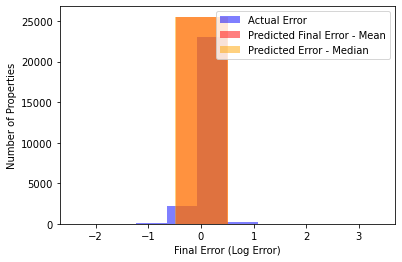

In [115]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.logerror, color='blue', alpha=.5, label="Actual Error")
plt.hist(y_train.logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Error - Mean")
plt.hist(y_train.logerror_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Error - Median")
plt.xlabel("Final Error (Log Error)")
plt.ylabel("Number of Properties")
plt.legend();

### Linear Regression (OLS)
1. Fit the model using X_train (scaled) and the labels from y_train.
2. Predict final logerror for properties in training sample using our model (lm).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.

In [116]:
# create the model object
# 
# make the thing

lm = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series 
 
# fit the thing
 
lm.fit(X_train_scaled, y_train.logerror)

LinearRegression(normalize=True)

In [117]:
# predict train
 
# use the thing! 
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (.57)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16298186939436773 
Validation/Out-of-Sample:  0.14242710255271934


In [118]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.163478       0.00000
1    OLS Regressor       0.142427       0.00075

### LassoLars
1. Fit the model using X_train_scaled and the labels from y_train.
2. Predict final log error for properties in training sample using our model (lars).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.

In [119]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (.6)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16313126773021655 
Validation/Out-of-Sample:  0.12846401072925018


In [120]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lars,
               'lasso_alpha_4',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.163478       0.00000
1    OLS Regressor       0.142427       0.00075
2    lasso_alpha_4       0.180850       0.00000

### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()


1. Create the new features, based on value indicated for degree for train, validate & test.
2. Fit the Linear Regression model
3. Predict using the transformed (squared or cubed, e.g.) features
4. Evaluate using RMSE
5. Repeat predictions and evaluation for validation.
6. Compare RMSE train vs. validation. Overfitting?

### Polynomial Features

In [121]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

### Linear Regression

In [122]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2) ** (.6)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16291450726809809 
Validation/Out-of-Sample:  0.1318559681681313


In [123]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lm2,
               'quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.163478      0.000000
1    OLS Regressor       0.142427      0.000750
2    lasso_alpha_4       0.180850      0.000000
3        quadratic       0.184820     -0.002485

In [124]:
# Trying degree of 3 to check performance

In [125]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 =  pf.transform(X_test_scaled)
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3) ** (1/2)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3) ** (.6)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16274309710145968 
Validation/Out-of-Sample:  0.15338761361344327


In [126]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lm3,
               '3degree_quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0    median_baseline       0.163478      0.000000
1      OLS Regressor       0.142427      0.000750
2      lasso_alpha_4       0.180850      0.000000
3          quadratic       0.184820     -0.002485
4  3degree_quadratic       0.209649     -0.016144

In [128]:
# After running different models, choosing OLS Regressor as the best model to use on test.  

## Evaluate
### Plotting Actual vs. Predicted Values

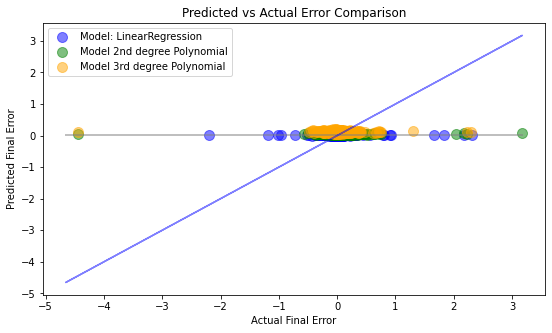

In [129]:
# y_validate.head()
plt.figure(figsize=(9,5))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
#plt.annotate("Baseline: Predict Using Mean", (10, 7))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')
#plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm.sample(n=1000), 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_glm.sample(n=1000), 
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm2.sample(n=1000), 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm3.sample(n=1000), 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Error")
plt.ylabel("Predicted Final Error")
plt.title("Predicted vs Actual Error Comparison");

### Residual Plots: Plotting Errors in Predictions

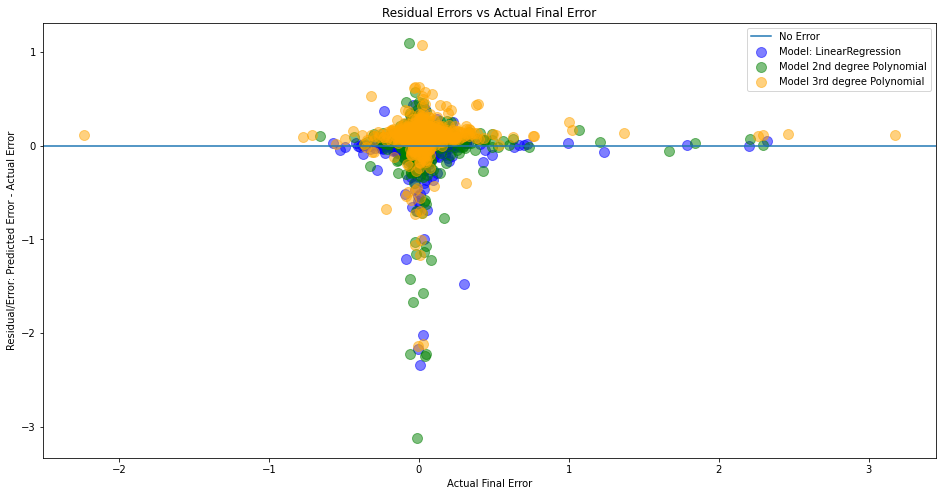

In [130]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
y_lm = y_validate.logerror_pred_lm - y_validate.logerror
#y_glm = y_validate.logerror_pred_glm - y_validate.logerror
y_lm2 = y_validate.logerror_pred_lm2 - y_validate.logerror
y_lm3 = y_validate.logerror_pred_lm3 - y_validate.logerror



plt.scatter(y_validate.logerror.sample(n=1000), y_lm.sample(n=1000) , 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.logerror.sample(n=1000), y_glm.sample(n=1000) , 
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror.sample(n=1000), y_lm2.sample(n=1000) , 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror.sample(n=1000), y_lm3.sample(n=1000) , 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Error")
plt.ylabel("Residual/Error: Predicted Error - Actual Error")
plt.title("Residual Errors vs Actual Final Error");
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3));

### Histograms 

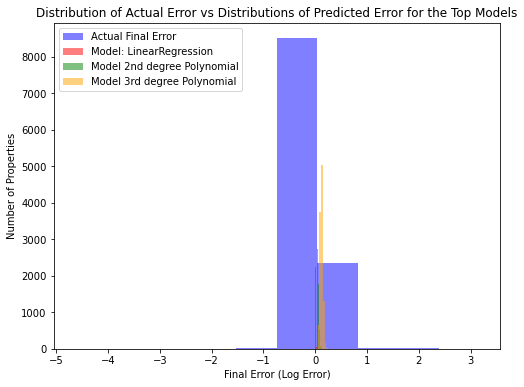

In [131]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(8,6))
plt.hist(y_validate.logerror, color='blue', alpha=.5, label="Actual Final Error")
plt.hist(y_validate.logerror_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.logerror_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.logerror_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.logerror_pred_lm3, color='orange', alpha=.5, label="Model 3rd degree Polynomial")
plt.xlabel("Final Error (Log Error)")
plt.ylabel("Number of Properties")
plt.title("Distribution of Actual Error vs Distributions of Predicted Error for the Top Models")
plt.legend();

# Modeling Takeaways:
Linear Regression Model performed better than the baseline by having the lowest RMSE and a $R^2$ of 0.000402. Although it performed better than the rest of the models, it does not look to be a significant predictor of error, just barely beating the baseline.

____

## Run the Model on Test Sample
### Model Selection & Out-of-Sample Evaluation
Model selected: LinearRegression

In [132]:
y_test = pd.DataFrame(y_test)

# predict test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (.6)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm) ** 0.5


print("RMSE for OLS using Linear Regression Model\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for OLS using Linear Regression Model
Training/In-Sample:  0.16298186939436773 
Validation/Out-of-Sample:  0.12854194988379317 
Test/Out-of-Sample:  0.15486871694876145


In [133]:
metric_df = wrangle.make_metric_df(y_test.logerror,
               y_test.logerror_pred_lm,
               'TEST_OLS',
               metric_df)
metric_df.style.format(
                formatter={('RMSE_validate', 'r^2_validate'): "{:.2f}",
                          })

# Final Takeaways:
 
____ 
 
### Technical Findings:
 - The Ordinary Least Squares (OLS) Linear Regression model performed best on validate and was chosen to be used on out of sample data
 - The Linear Regression model was able to beat the baseline thus possibly reduce log error in actual predictions
 
### What Does This Mean for our Zestimate?
 - Our model may be able to reduce log error by 3%
 - Features chosen for the model that may be drivers of error include bedrooms, bathrooms, square footage, latitude and longitude
 - Even though the model performed slightly better than the baseline, all models seem to indicate that there may not be many significant drivers of log error in this data.
 
### Next Steps:
 - With more time, I would like to try running models on the clusters since they showed dependency on log error
 - I would also like to keep exploring other features and clusters in the models